# Importacion de librerias

In [62]:
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
#Visualizacion de graficas
plt.style.use('seaborn-v0_8-darkgrid')

# Importacion de la base de datos

Creamos el df con la base de datos .csv.

In [5]:
ercot_fwes = pd.read_csv('ercot_fwes_complete_2019-2025.csv')

# Analisis exploratorio y limpieza de la base de datos

Desplegamos las primeras y ultimas filas de la base de datos.

In [6]:
ercot_fwes.head()

timestamp  value
0  2019-05-27 06:00:00   3231
1  2019-05-27 07:00:00   3231
2  2019-05-27 08:00:00   3256
3  2019-05-27 09:00:00   3266
4  2019-05-27 10:00:00   3238

In [7]:
ercot_fwes.tail()

timestamp  value
49088  2024-12-31 20:00:00   7370
49089  2024-12-31 21:00:00   7411
49090  2024-12-31 22:00:00   7429
49091  2024-12-31 23:00:00   7432
49092  2025-01-01 00:00:00   7268

Observamos la estructura general del dataframe.

In [8]:
print("\nInformación del DataFrame:")
ercot_fwes.info()


Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49093 entries, 0 to 49092
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  49093 non-null  object
 1   value      49093 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 767.2+ KB


Realizamos un analisis exploratorio de los datos.

In [9]:
ercot_fwes.describe()

value
count  49093.000000
mean    4839.659870
std     1244.605858
min     1087.000000
25%     3780.000000
50%     4391.000000
75%     5974.000000
max     8463.000000

Analizamos si existen outliers en la base de datos mediante un boxplot.

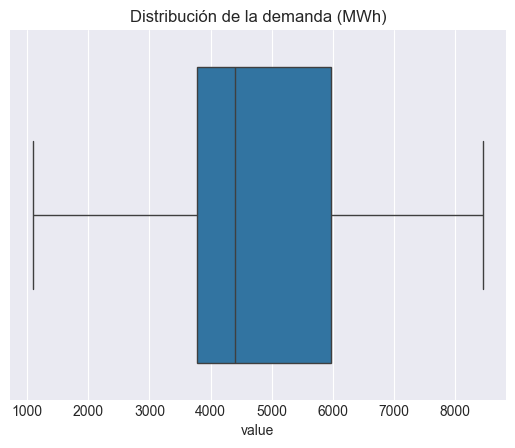

In [10]:
sns.boxplot(x=ercot_fwes['value'])
plt.title("Distribución de la demanda (MWh)")
plt.show()

Convertimos la variable timestamp en una variable a tipo datetime y verificamos la ordenación de los datos.

In [11]:
ercot_fwes['timestamp'] = pd.to_datetime(ercot_fwes['timestamp'])
ercot_fwes = ercot_fwes.sort_values('timestamp').reset_index(drop=True)
ercot_fwes.index.is_monotonic_increasing

True

Verificamos que no existan valores faltantes y datos duplicados.

In [12]:
print(ercot_fwes.isna().sum())

timestamp    0
value        0
dtype: int64


In [13]:
print(f"Duplicados: {ercot_fwes.duplicated().sum()} filas")

Duplicados: 0 filas


Para aplicar el modelo LSTM que trabaja con datos temporales tenemos que asegurarnos que exista una frecuencia horaria constante en nuestra base de datos, en este caso de una hora entre cada registro.

In [14]:
ercot_fwes['diff'] = ercot_fwes['timestamp'].diff()
print(ercot_fwes['diff'].value_counts().head())

diff
0 days 01:00:00    49086
0 days 02:00:00        6
Name: count, dtype: int64


Existen 6 registros con un salto de 2 horas. Para solucionar el problema primero haremos un reindex para establecer la columna 'timestamp' como el indice de la base de datos y realizamos una interpolación lineal para rellenar los espacios faltantes (los espacios en donde habia un salto de 2 horas).

Por practicidad renombraremos la columna 'value' por 'demand_MWh'.

In [15]:
#establecemos el timestamp como índice
ercot_fwes.set_index('timestamp', inplace=True)

In [16]:
date_range_full = pd.date_range(
    start=ercot_fwes.index.min(),
    end=ercot_fwes.index.max(),
    freq='1h'
)
ercot_fwes = ercot_fwes.reindex(date_range_full)
ercot_fwes.index.name = 'timestamp'

In [17]:
ercot_fwes['demand_MWh'] = ercot_fwes['value'].interpolate(method='linear')

Confirmamos que no existan valores faltantes.

In [18]:
print("Valores faltantes restantes:", ercot_fwes['demand_MWh'].isna().sum())

Valores faltantes restantes: 0


Eliminamos la columna 'diff' y la columna 'value' y solo conservamos 'demand_MWh'.

In [19]:
ercot_fwes.drop(columns=['value', 'diff'], inplace=True)

Imprimimos la nueva dimensión de la base de datos.

In [20]:
ercot_fwes.shape

(49099, 1)

Verificamos que todos los datos esten espaciados en una hora.

In [21]:
print(ercot_fwes.index.to_series().diff().value_counts())

timestamp
0 days 01:00:00    49098
Name: count, dtype: int64


Podemos graficar la demanda de cada año completo (2020-2024) para dar una idea de los datos con los que estaremos tratando.

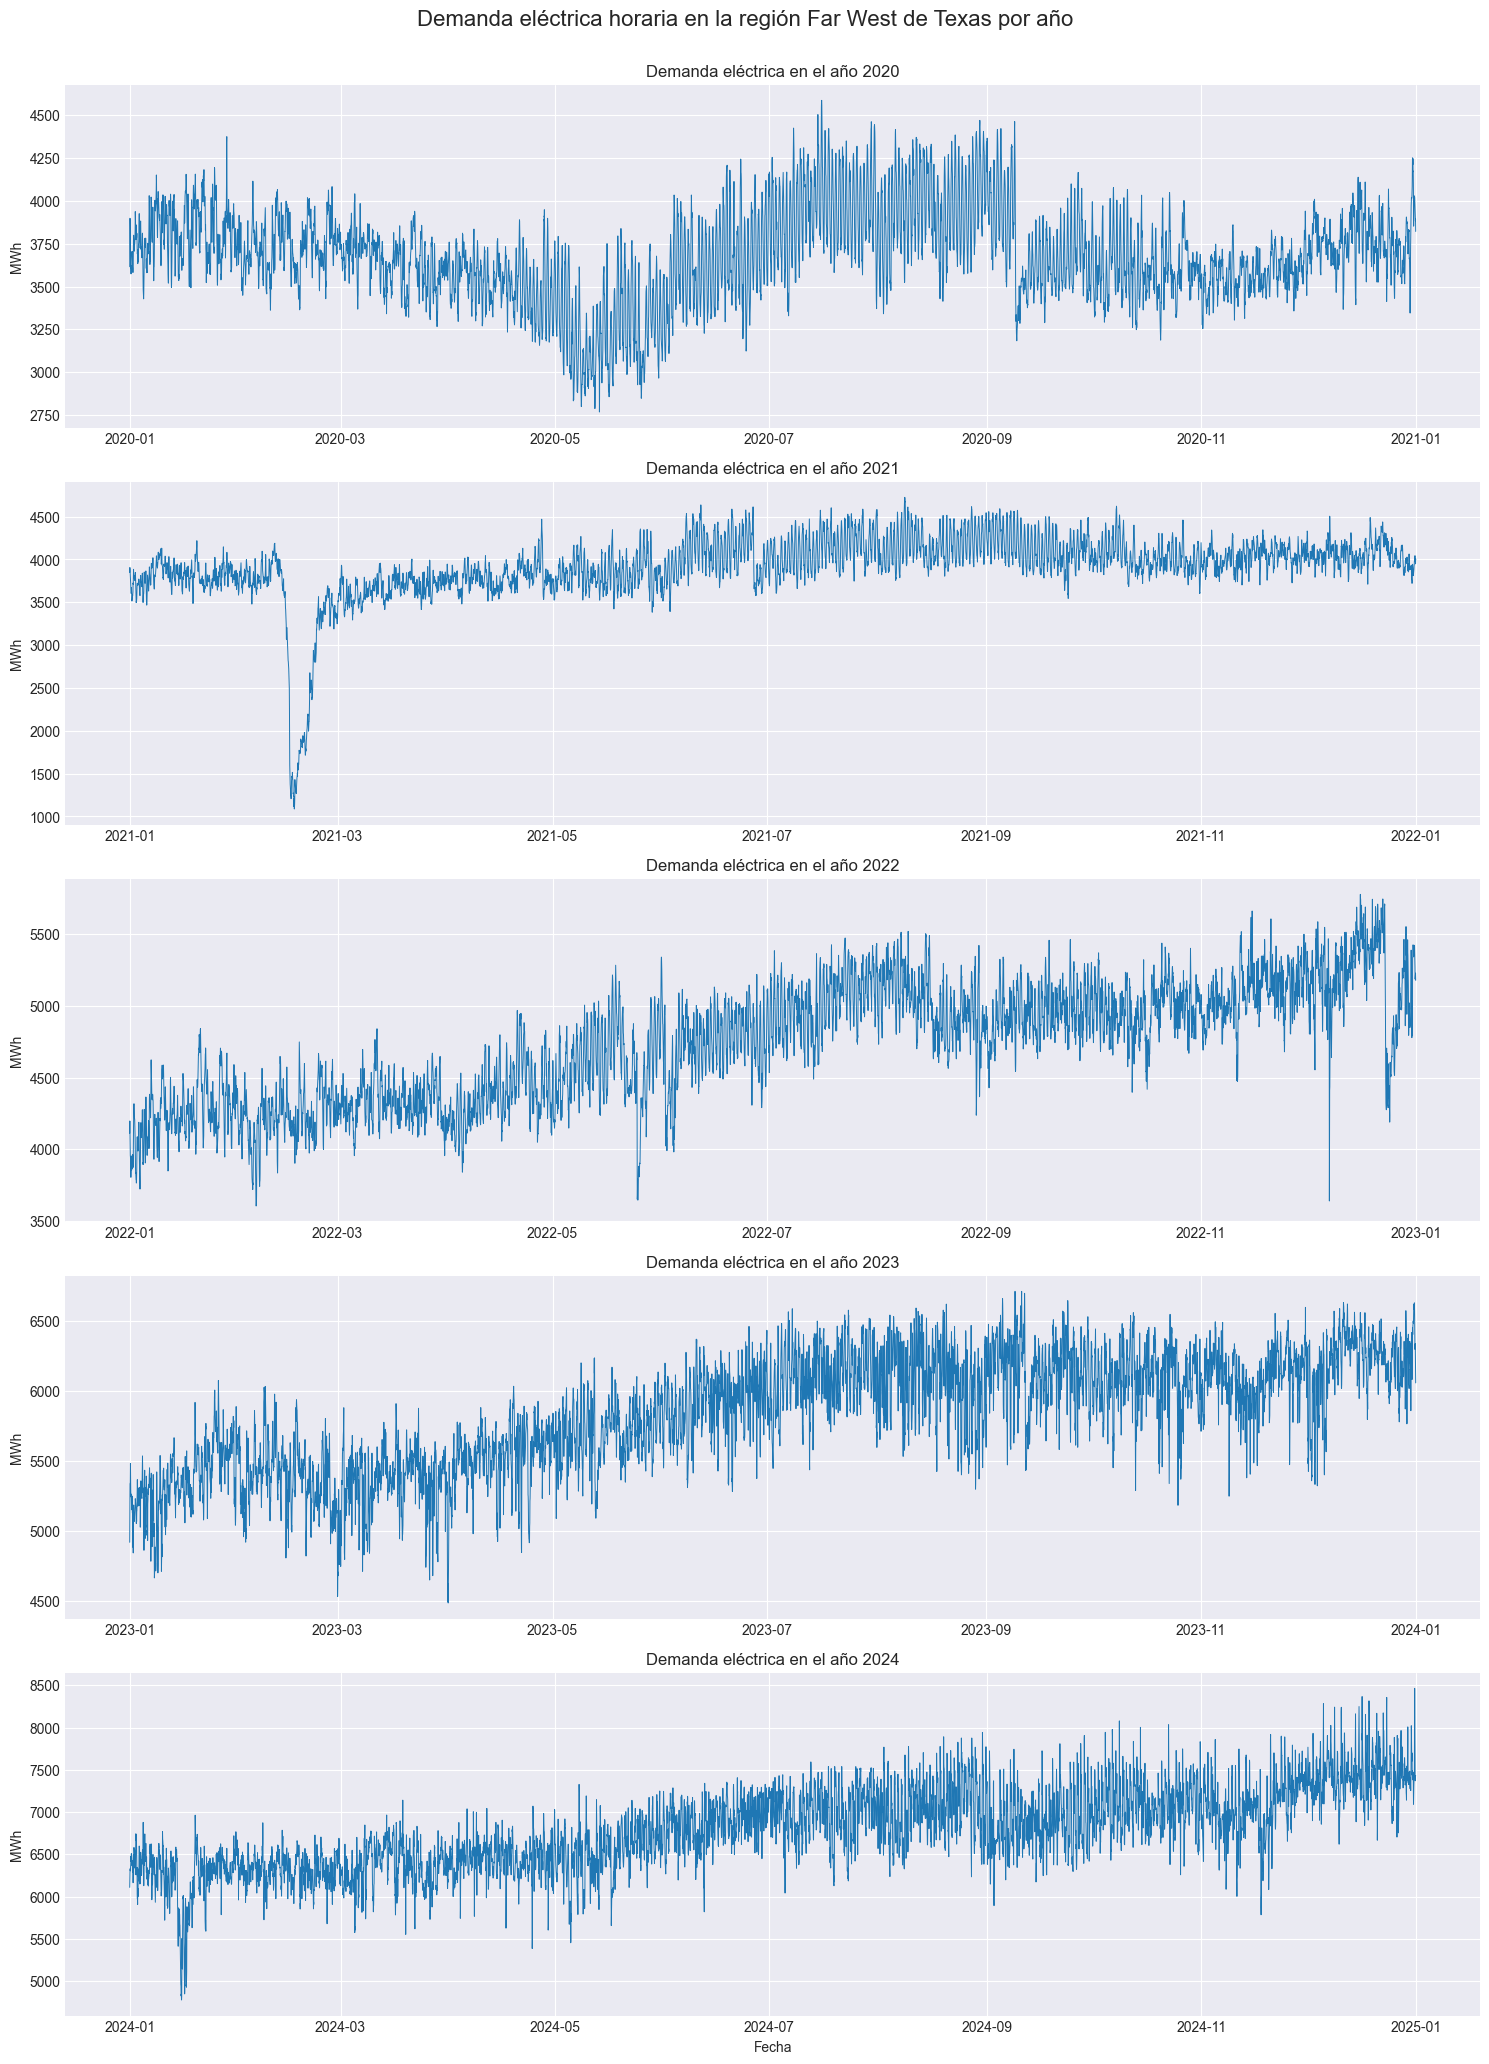

In [22]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 20), sharex=False)

years = [2020, 2021, 2022, 2023, 2024]

#subplots para cada año
for i, year in enumerate(years):
    yearly_data = ercot_fwes.loc[str(year)]
    
    axes[i].plot(yearly_data.index, yearly_data['demand_MWh'], color='tab:blue', linewidth=0.7)
    axes[i].set_title(f'Demanda eléctrica en el año {year}', fontsize=12)
    axes[i].set_ylabel('MWh')
    axes[i].grid(True)

plt.tight_layout()
plt.xlabel("Fecha")
plt.suptitle("Demanda eléctrica horaria en la región Far West de Texas por año", fontsize=16, y=1.02)
plt.show()

# Aplicacion del modelo LSTM

## Escalamiento de los datos

Comenzamos aplicando un MinMaxScaler a los datos de la demanda de energía.

In [23]:
#Aplicamos MinMaxScaler para escalar la demanda entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
demand_scaled = scaler.fit_transform(ercot_fwes[['demand_MWh']])

#Añadimos la columna de la demanda escalada al DataFrame
ercot_fwes['demand_scaled'] = demand_scaled

#Imprimimos el dataframe para confirmar el escalamiento
ercot_fwes[['demand_MWh', 'demand_scaled']].head()

demand_MWh  demand_scaled
timestamp                                     
2019-05-27 06:00:00      3231.0       0.290672
2019-05-27 07:00:00      3231.0       0.290672
2019-05-27 08:00:00      3256.0       0.294062
2019-05-27 09:00:00      3266.0       0.295418
2019-05-27 10:00:00      3238.0       0.291621

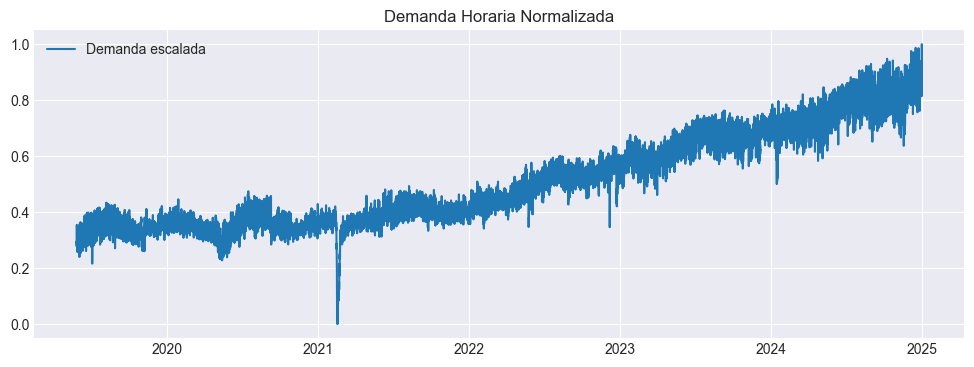

In [24]:
#Grafica de la totalidad de los datos escalados
plt.figure(figsize=(12, 4))
plt.plot(ercot_fwes.index, ercot_fwes['demand_scaled'], label='Demanda escalada')
plt.title('Demanda Horaria Normalizada')
plt.legend()
plt.show()

## Creación de secuencias

Primero definimos la función para crear las secuencias de entrada y etiquetas de salida.

In [25]:
def create_sequences(data, time_step):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])  #Secuencia de las últimas time_step horas
        y.append(data[i, 0])  #La demanda de la hora objetivo
    return np.array(X), np.array(y)

Usaremos un time_step de 168 horas (1 semana), para poder predecir la demanda en algun dia y hora arbitrarios.

In [26]:
time_step = 168
X, y = create_sequences(ercot_fwes[['demand_scaled']].values, time_step) #secuencias con la variable escalada
X = X.reshape(X.shape[0], X.shape[1], 1)

Verificamos las dimensiones de X, y.

In [27]:
print(f"X.shape: {X.shape}")
print(f"y.shape: {y.shape}")

X.shape: (48931, 168, 1)
y.shape: (48931,)


## Implementación del modelo LSTM

Primero dividimos los conjuntos de datos en un conjunto de prueba y uno de entrenamiento.

In [28]:
#80% entrenamiento/20% prueba (sin mezclar)
split_idx = int(len(X) * 0.8)
X_train, y_train = X[:split_idx], y[:split_idx]
X_test, y_test = X[split_idx:], y[split_idx:]

print(f"Train shapes: {X_train.shape}, {y_train.shape}")
print(f"Test shapes: {X_test.shape}, {y_test.shape}")

Train shapes: (39144, 168, 1), (39144,)
Test shapes: (9787, 168, 1), (9787,)


Comenzamos a construir el modelo LSTM con el optimizador ADAM.

In [30]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(time_step, 1)),
    Dropout(0.2),
    LSTM(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
#Se utilizó el optimizador adam con su learning rate predeterminado de 0.001
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 168, 64)        │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 168, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,345 (114.63 KB)

 Trainable params: 29,345 (114.63 KB)

 Non-trainable params: 0 (0.00 B)

Ahora con el modelo LSTM definido realizamos el entrenamiento con los datos X_train y y_train. Implementamos EarlyStopping para detener el entrenamiento basandonos en el error de validación cuando el modelo deje de mejorar. También agregamos ModelCheckpoint para guardar el modelo con el mejor rendimiento durante el entrenamiento para no perder el progreso en caso de existir un sobreajuste.

In [41]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.h5',        
    monitor='val_loss',     
    save_best_only=True,    
    mode='min',
    verbose=1 
)

In [42]:
history = model.fit(
    X_train, y_train,
    epochs=100,  
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/100
1223/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0014 - mse: 0.0014
Epoch 1: val_loss improved from inf to 0.00089, saving model to best_model.h5


1224/1224 ━━━━━━━━━━━━━━━━━━━━ 78s 64ms/step - loss: 0.0014 - mse: 0.0014 - val_loss: 8.9023e-04 - val_mse: 8.9023e-04
Epoch 2/100
1223/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 6.3717e-04 - mse: 6.3717e-04
Epoch 2: val_loss improved from 0.00089 to 0.00083, saving model to best_model.h5


1224/1224 ━━━━━━━━━━━━━━━━━━━━ 77s 63ms/step - loss: 6.3702e-04 - mse: 6.3702e-04 - val_loss: 8.2707e-04 - val_mse: 8.2707e-04
Epoch 3/100
1223/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 4.2216e-04 - mse: 4.2216e-04
Epoch 3: val_loss improved from 0.00083 to 0.00062, saving model to best_model.h5


1224/1224 ━━━━━━━━━━━━━━━━━━━━ 81s 66ms/step - loss: 4.2211e-04 - mse: 4.2211e-04 - val_loss: 6.1961e-04 - val_mse: 6.1961e-04
Epoch 4/100
1223/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 3.4258e-04 - mse: 3.4258e-04
Epoch 4: val_loss did not improve from 0.00062
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 77s 63ms/step - loss: 3.4256e-04 - mse: 3.4256e-04 - val_loss: 6.7060e-04 - val_mse: 6.7060e-04
Epoch 5/100
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 2.9020e-04 - mse: 2.9020e-04
Epoch 5: val_loss improved from 0.00062 to 0.00038, saving model to best_model.h5


1224/1224 ━━━━━━━━━━━━━━━━━━━━ 84s 68ms/step - loss: 2.9020e-04 - mse: 2.9020e-04 - val_loss: 3.7858e-04 - val_mse: 3.7858e-04
Epoch 6/100
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 2.6388e-04 - mse: 2.6388e-04
Epoch 6: val_loss did not improve from 0.00038
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - loss: 2.6388e-04 - mse: 2.6388e-04 - val_loss: 5.1512e-04 - val_mse: 5.1512e-04
Epoch 7/100
1223/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 2.5976e-04 - mse: 2.5976e-04
Epoch 7: val_loss did not improve from 0.00038
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - loss: 2.5976e-04 - mse: 2.5976e-04 - val_loss: 6.0732e-04 - val_mse: 6.0732e-04
Epoch 8/100
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 2.5072e-04 - mse: 2.5072e-04
Epoch 8: val_loss did not improve from 0.00038
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 82s 67ms/step - loss: 2.5072e-04 - mse: 2.5072e-04 - val_loss: 4.0289e-04 - val_mse: 4.0289e-04
Epoch 9/100
1223/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 2.4598e-

1224/1224 ━━━━━━━━━━━━━━━━━━━━ 81s 67ms/step - loss: 2.4598e-04 - mse: 2.4598e-04 - val_loss: 3.5474e-04 - val_mse: 3.5474e-04
Epoch 10/100
1223/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 2.4336e-04 - mse: 2.4336e-04
Epoch 10: val_loss did not improve from 0.00035
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 81s 66ms/step - loss: 2.4336e-04 - mse: 2.4336e-04 - val_loss: 4.4623e-04 - val_mse: 4.4623e-04
Epoch 11/100
1223/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.3081e-04 - mse: 2.3081e-04
Epoch 11: val_loss did not improve from 0.00035
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 77s 63ms/step - loss: 2.3081e-04 - mse: 2.3081e-04 - val_loss: 5.0933e-04 - val_mse: 5.0933e-04
Epoch 12/100
1223/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 2.3715e-04 - mse: 2.3715e-04
Epoch 12: val_loss improved from 0.00035 to 0.00035, saving model to best_model.h5


1224/1224 ━━━━━━━━━━━━━━━━━━━━ 78s 64ms/step - loss: 2.3715e-04 - mse: 2.3715e-04 - val_loss: 3.4999e-04 - val_mse: 3.4999e-04
Epoch 13/100
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 2.3988e-04 - mse: 2.3988e-04
Epoch 13: val_loss did not improve from 0.00035
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 77s 63ms/step - loss: 2.3989e-04 - mse: 2.3989e-04 - val_loss: 7.6942e-04 - val_mse: 7.6942e-04
Epoch 14/100
1223/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.3362e-04 - mse: 2.3362e-04
Epoch 14: val_loss did not improve from 0.00035
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 84s 69ms/step - loss: 2.3362e-04 - mse: 2.3362e-04 - val_loss: 5.0991e-04 - val_mse: 5.0991e-04
Epoch 15/100
1223/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2.2903e-04 - mse: 2.2903e-04
Epoch 15: val_loss did not improve from 0.00035
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 84s 69ms/step - loss: 2.2904e-04 - mse: 2.2904e-04 - val_loss: 5.0306e-04 - val_mse: 5.0306e-04
Epoch 16/100
1224/1224 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 2

# Evaluación del modelo

Usaremos nuestro modelo para predecir la demanda electrica en el primer trimestre del año 2025 con los datos obtenidos de EIA.

In [144]:
ercot_fwes_25 = pd.read_csv('ercot_fwes_010125-033125.csv')

In [145]:
ercot_fwes_25['timestamp'] = pd.to_datetime(ercot_fwes_25['timestamp'])
ercot_fwes_25.set_index('timestamp', inplace=True)
ercot_fwes_25.head()

value
timestamp                 
2025-01-01 00:00:00   7268
2025-01-01 01:00:00   6790
2025-01-01 02:00:00   7206
2025-01-01 03:00:00   7611
2025-01-01 04:00:00   7682

Realizamos la normalizacion de los datos aplicando el mismo scaler que a los datos utilizados para en entrenamiento.

In [146]:
#Normalizar los valores con el mismo scaler del entrenamiento
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(ercot_fwes[['demand_MWh']])
joblib.dump(scaler, 'min_max_scaler.pkl')

['min_max_scaler.pkl']

In [147]:
ercot_fwes_25 = ercot_fwes_25.rename(columns={'value': 'demand_MWh'})
ercot_fwes_25['demand_scaled'] = scaler.transform(ercot_fwes_25[['demand_MWh']])

In [148]:
#Valor máximo de demand_scaled
max_scaled = ercot_fwes_25['demand_scaled'].max()
print(f"Valor máximo de demand_scaled: {max_scaled}")

#Verificacion de valores fuera de 0-1
out_of_bounds = ercot_fwes_25[(ercot_fwes_25['demand_scaled'] < 0) | (ercot_fwes_25['demand_scaled'] > 1)]
print(f"\nNumero de valores fuera del rango [0, 1]: {len(out_of_bounds)}")

Valor máximo de demand_scaled: 0.9934924078091105

Numero de valores fuera del rango [0, 1]: 0


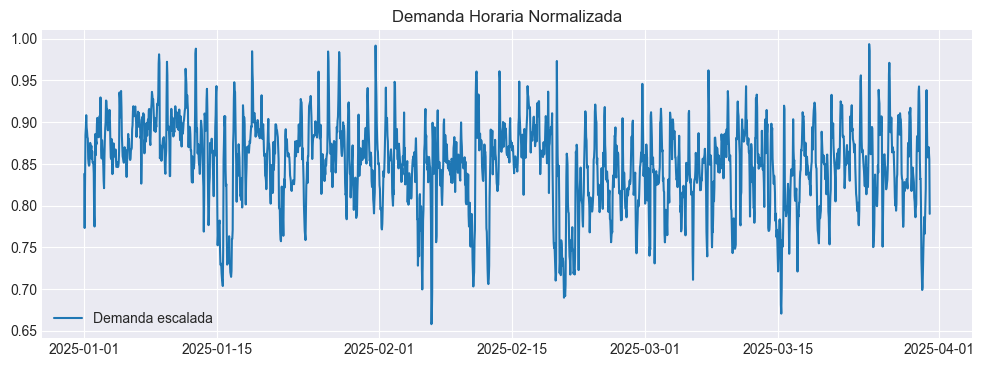

In [149]:
#Grafica de la totalidad de los datos escalados
plt.figure(figsize=(12, 4))
plt.plot(ercot_fwes_25.index, ercot_fwes_25['demand_scaled'], label='Demanda escalada')
plt.title('Demanda Horaria Normalizada')
plt.legend()
plt.show()

Ahora creamos las secuencias temporales para predecir la demanda en el primer trimestre del 2025 utilizando el mejor modelo obtenido durante el entrenamiento.

In [150]:
# Cargar el modelo entrenado
model = load_model('best_model.h5')

In [151]:
#Crear secuencias temporales 
def create_sequences(data, window_size=168):
    X = []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
    return np.array(X)

X_2025 = create_sequences(ercot_fwes_25['demand_scaled'].values)
X_2025 = X_2025.reshape(X_2025.shape[0], X_2025.shape[1], 1)  # Shape: (muestras, 168, 1)

#Predecir todas las secuencias
y_pred_scaled = model.predict(X_2025)
y_pred = scaler.inverse_transform(y_pred_scaled).flatten()  # Revertir escalamiento

#Alinear con timestamps reales (descartando primeras 168 horas/primera semana)
timestamps = ercot_fwes_25.index[168:]
real_values = ercot_fwes_25['demand_MWh'].values[168:]

62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


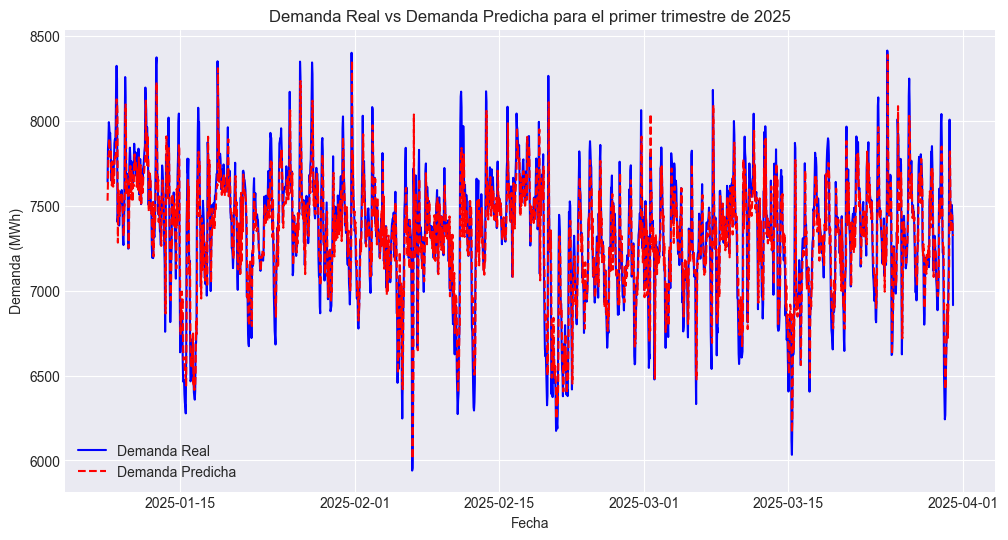

In [152]:
plt.figure(figsize=(12, 6))
plt.plot(ercot_fwes_25.index[time_step:], ercot_fwes_25['demand_MWh'][time_step:], label='Demanda Real', color='blue')
plt.plot(predicted_df.index, predicted_df['predicted_demand'], label='Demanda Predicha', color='red', linestyle='--')
plt.title('Comparacion Entre Demanda Real y Demanda Predicha para el Primer Trimestre de 2025')
plt.xlabel('Fecha')
plt.ylabel('Demanda (MWh)')
plt.legend()
plt.show()

In [159]:
# Calcular R-squared mensual
r_squared_monthly = []

# Agrupar por mes y calcular el R-squared para cada mes
for month, group in predicted_df.groupby(predicted_df.index.month):
    # Filtrar los valores reales para el mismo mes que las predicciones
    real_for_month = real_values[predicted_df.index.month == month]
    pred_for_month = group['predicted_demand']
    
    r_squared = r2_score(real_for_month, pred_for_month)
    r_squared_monthly.append((month, r_squared))

    print(f'R-squared para el mes {month}: {r_squared}')

# Gráfico interactivo con Plotly
fig = go.Figure()

# Añadir la línea de la demanda real
fig.add_trace(go.Scatter(
    x=ercot_fwes_25.index[168:],
    y=real_values,
    mode='lines',
    name='Demanda Real',
    line=dict(color='blue')
))

# Añadir la línea de la demanda predicha
fig.add_trace(go.Scatter(
    x=predicted_df.index,
    y=predicted_df['predicted_demand'],
    mode='lines',
    name='Demanda Predicha',
    line=dict(color='red', dash='dash')
))

fig.update_layout(
    title='Comparacion Entre Demanda Real y Demanda Predicha para el Primer Trimestre de 2025',
    xaxis_title='Fecha',
    yaxis_title='Demanda (MWh)',
    template='seaborn',
    legend=dict(x=0, y=1, traceorder='normal', orientation='h')
)

fig.show()

R-squared para el mes 1: 0.7919034957885742
R-squared para el mes 2: 0.7737709283828735
R-squared para el mes 3: 0.7298067808151245


C:\Users\PC\anaconda3\envs\notebook-6.5.7\Lib\site-packages\plotly\io\_renderers.py:55: UserWarning:

Plotly version >= 6 requires Jupyter Notebook >= 7 but you have 6.5.7 installed.
 To upgrade Jupyter Notebook, please run `pip install notebook --upgrade`.

